Danayal

TODO: Slice the sound file into slices of 0.5 seconds each and then further slice them into 0.05 seconds frames. Then calculate MMCC for reach frame

In [24]:
# Load various imports 
from datetime import datetime
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display

import numpy as np
import pandas as pd


from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
mypath = "respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/"
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))] 

In [3]:
p_id_in_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np.array(p_id_in_file) 

In [4]:
max_pad_len = 862 # to make the length of all MFCC equal

def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it, and returns the MFCC
    of the audio"""
  



#res_type is is the resampling type. kaiser_fast is high-quality mode
#need to change librosa.load into librosa.core.load

    try:
        audio, sample_rate = librosa.core.load(file_name, res_type='kaiser_fast', duration=20) #most of the recordings are 20 seconds long
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40) #value for n_mfcc is abritrary
        pad_width = max_pad_len - mfccs.shape[1] #to feed it into the model
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [5]:
filepaths = [join(mypath, f) for f in filenames] # full paths of files


In [6]:
p_diag = pd.read_csv("respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv",header=None) # patient diagnosis file

In [7]:
p_diag

,0,1
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI
...,...,...
121,222,COPD
122,223,COPD
123,224,Healthy
124,225,Healthy


In [8]:
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) # labels for audio files

In [10]:
features = [] 

# Iterate through each sound file and extract the features


#features in this case are the mfcss



for file_name in filepaths:
    data = extract_features(file_name)
    features.append(data)

#print('Finished feature extraction from ', len(features), ' files')
features = np.array(features)

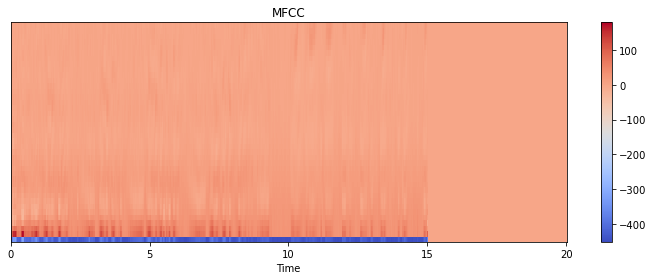

In [11]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(features[7], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [12]:
features = np.array(features) # convert to numpy array


In [13]:
# delete the very rare diseases
features1 = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0) 

labels1 = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)


In [14]:
# print class counts
unique_elements, counts_elements = np.unique(labels1, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
 ['16' '13' '793' '35' '37' '23']]


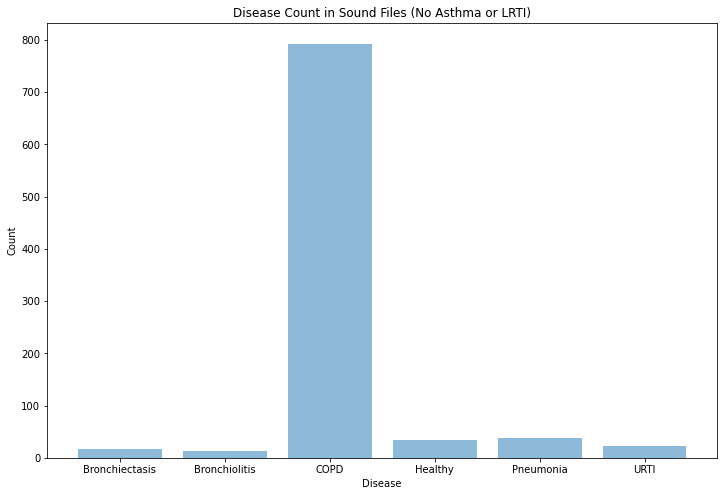

In [15]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files (No Asthma or LRTI)')
plt.show()

Since the number of COPID is much larger than the rest of the labels, need to perform <b>data augmentation, downsampling, and upsampling</b> to get more balanced data

<h3><b> Data Augmentation </h3> </b>

Following https://www.kaggle.com/CVxTz/audio-data-augmentation data augmentation tutorial

This includes adding white noise, shifting, and stretching the audio.

White noise dominates the sound too much.
Shifting the sound could be a good option.
Stetching the sound changes the charactersitics of the sound too much.


In [16]:
import numpy as np
import random
import itertools
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt


In [17]:
def load_audio_file(file_path):
    
    #need to change input length to 20 seconds long
    input_length = 16000 *20
    data = librosa.core.load(file_path)[0] #, sr=16000
    if len(data)>input_length:
        data = data[:input_length]
    else:
        data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
    return data
def plot_time_series(data):
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 20, len(data)), data)
    plt.show()

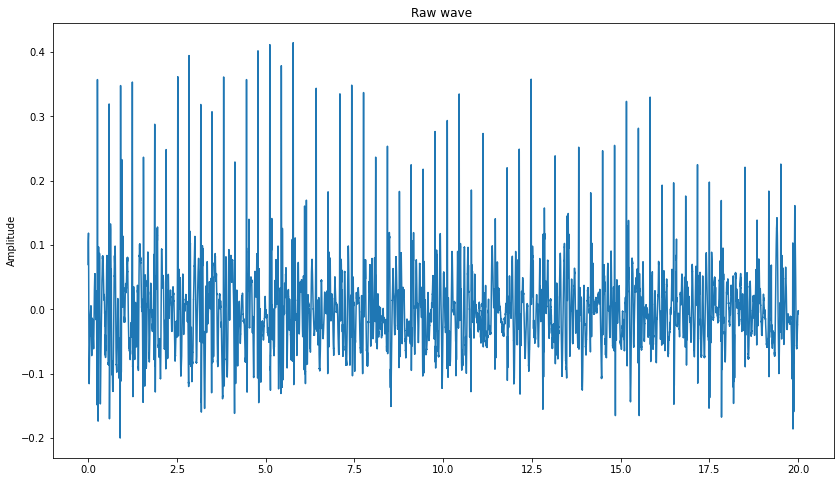

In [18]:
data = load_audio_file("respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav")
plot_time_series(data)

In [19]:
ipd.Audio(data, rate=16000)

Adding white noise

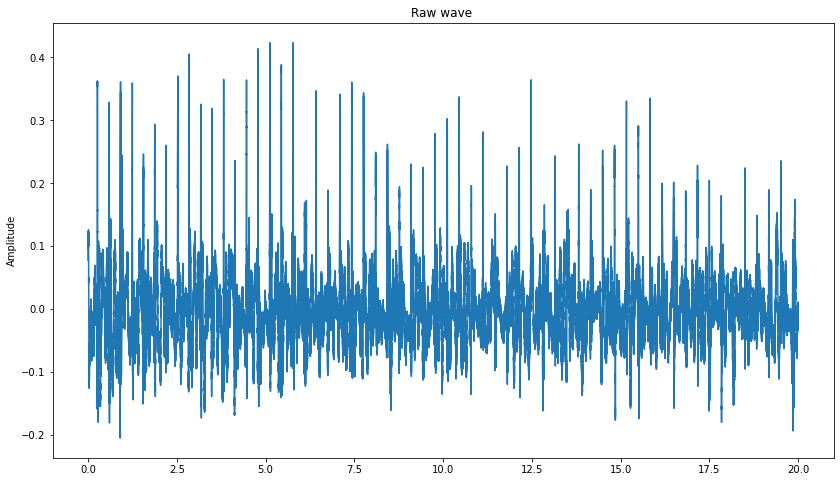

In [20]:
# Adding white noise 
wn = np.random.randn(len(data))
data_wn = data + 0.005*wn
plot_time_series(data_wn)
# We limited the amplitude of the noise so we can still hear the word even with the noise, 
#which is the objective
ipd.Audio(data_wn, rate=16000)

White noise dominates the sound too much.. Not a good option?

Shifting the sound

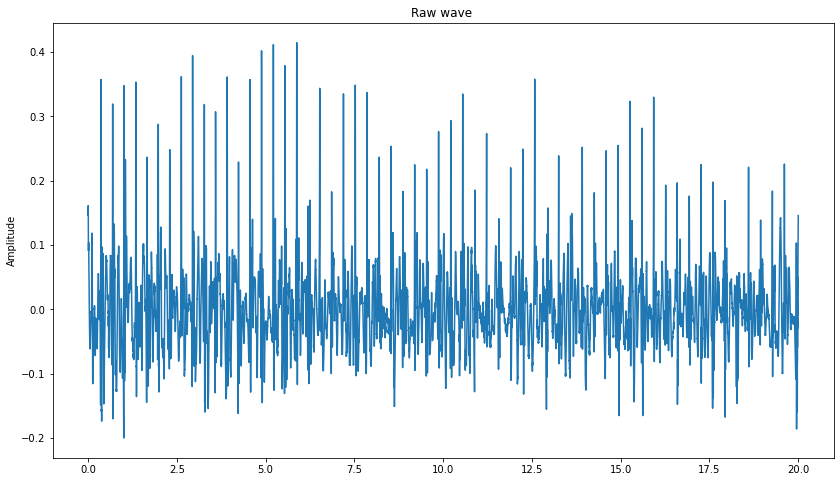

In [21]:
# Shifting the sound
data_roll = np.roll(data, 1600)
plot_time_series(data_roll)
ipd.Audio(data_roll, rate=16000)

May be a good option

Stretching the sound

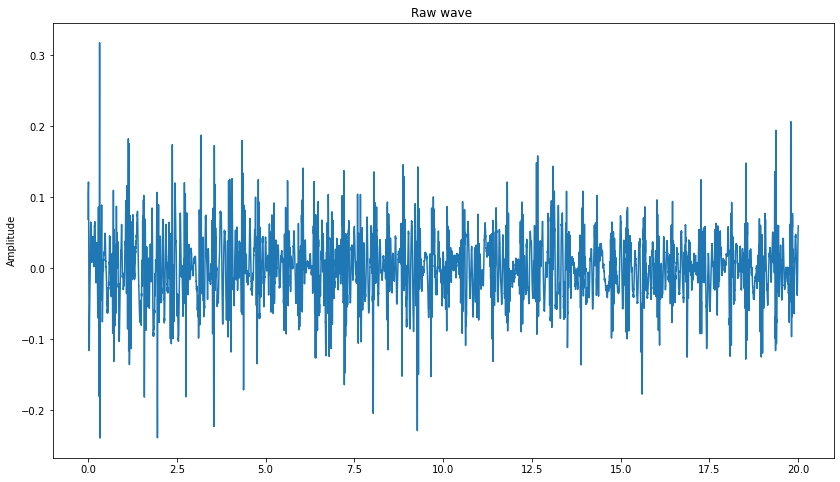

Higher frequencies  


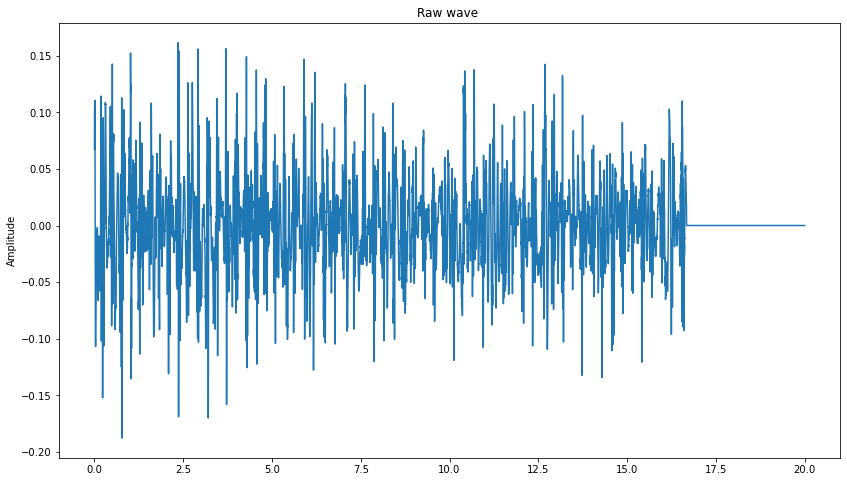

In [22]:
def stretch(data, rate=1):
    input_length = 16000 *20
    data = librosa.effects.time_stretch(data, rate)
    if len(data)>input_length:
        data = data[:input_length]
    else:
        data = np.pad(data, (0, max(0, input_length - len(data))), "constant")

    return data


data_stretch =stretch(data, 0.8)
plot_time_series(data_stretch)
ipd.Audio(data_stretch, rate=16000)

data_stretch =stretch(data, 1.2)
print("Higher frequencies  ")
plot_time_series(data_stretch)
ipd.Audio(data_stretch, rate=16000)

Sounds like a werewolf breathing under a full moon.. may not be a good option